### Домашнее задание_2

In [187]:
import pandas as pd
import numpy as np

In [188]:
news = pd.read_csv("./articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [189]:
news.iloc[0]['title']

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

Загрузим пользователей и списки последних прочитанных новостей

In [190]:
users = pd.read_csv("./users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [191]:
!pip install razdel pymorphy2 pyLDAvis

In [192]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

Не все слова равны, не все слова одинаково работают. К примеру, союзы и предлоги в нашей задачи никак не помогут, поэтому можем их выкидывать. (*Но в задачах оценки стиля, к примеру, такие слова будут очень полезны*)

In [193]:
# import nltk
# nltk.download('stopwords')

In [194]:
!pip install nltk

In [195]:
# import nltk
# nltk.download('stopwords')

In [196]:
  import nltk
  stopwords = nltk.corpus.stopwords.words('english')
  print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [197]:
stopword_ru = nltk.corpus.stopwords.words('russian')
print(len(stopword_ru))

151


In [198]:
stopword_ru[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [199]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [200]:
# !wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

In [201]:
with open('./stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [202]:
stopword_ru[0:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [203]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [204]:
morph = pymorphy2.MorphAnalyzer()
morph.parse('позавтракали')[0].normal_form

'позавтракать'

In [205]:
news['title'].iloc[:2].apply(lambda x: clean_text(x))

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [206]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [00:32<00:00, 819.90it/s]

Wall time: 33 s


In [207]:
news['title'].iloc[:10]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
2    форвард авангарда томаш заборский прокомментир...
3    главный тренер кубани юрий красножан прокоммен...
4    решением попечительского совета владивостокско...
5    ио главного тренера вячеслав буцаев прокоммент...
6    запорожский металлург дома потерпел разгромное...
7    сборная сша одержала победу над австрией со сч...
8    бывший защитник сборной россии дарюс каспарайт...
9    полузащитник цска зоран тошич после победы над...
Name: title, dtype: object

In [208]:
news['title'].iloc[:2].apply(lambda x: lemmatization(x))

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
Name: title, dtype: object

In [209]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 27000/27000 [05:06<00:00, 88.10it/s]

Wall time: 5min 6s


А теперь в 3 строчки обучим нашу модель

In [210]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [211]:
len(common_dictionary)

135723

In [212]:
common_dictionary[4]

'банк'

In [213]:
common_dictionary.id2token

{0: 'александр',
 1: 'алексей',
 2: 'андрей',
 3: 'армеец',
 4: 'банк',
 5: 'баскетбол',
 6: 'близкий',
 7: 'блок',
 8: 'борьба',
 9: 'ватутин',
 10: 'взаимодействие',
 11: 'власть',
 12: 'войти',
 13: 'вячеслав',
 14: 'генералполковник',
 15: 'генеральный',
 16: 'георгий',
 17: 'гмк',
 18: 'директор',
 19: 'европа',
 20: 'единогласно',
 21: 'заместитель',
 22: 'заседание',
 23: 'защита',
 24: 'иванов',
 25: 'избрать',
 26: 'исакович',
 27: 'клиентский',
 28: 'клуб',
 29: 'конституционный',
 30: 'корпоративный',
 31: 'леонид',
 32: 'лопат',
 33: 'министр',
 34: 'мир',
 35: 'начальник',
 36: 'никель',
 37: 'новак',
 38: 'норильский',
 39: 'оао',
 40: 'обсуждение',
 41: 'округ',
 42: 'ольга',
 43: 'ооо',
 44: 'орган',
 45: 'основной',
 46: 'пбк',
 47: 'первый',
 48: 'перспектива',
 49: 'планирование',
 50: 'плешаков',
 51: 'политика',
 52: 'полномочный',
 53: 'полтавец',
 54: 'полтавченко',
 55: 'правительство',
 56: 'правление',
 57: 'председатель',
 58: 'представитель',
 59: 'президент

In [214]:
common_dictionary.doc2bow(['коллега', 'пошел', 'пить', 'чай'], allow_update=True)

[(1036, 1), (6204, 1), (12347, 1), (135723, 1)]

Все просто - это словарь наших слов

Запускаем обучение

In [215]:
N_topic = 20

In [216]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

Wall time: 50.9 s


In [217]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [218]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [219]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(4, 0.08506847),
 (7, 0.2705121),
 (11, 0.108580515),
 (18, 0.15863094),
 (19, 0.3599892)]

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [220]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: газ германия производитель украина мышь продолжительность польша
topic_1: эстония гонконг ткачёв запрашивать кудрявцев тайвань янг
topic_2: военный статья район который человек время поверхность
topic_3: ракета северный запуск вода экипаж км берег
topic_4: год млрд млн рубль цена рынок станция
topic_5: год компания фонд который источник участок проект
topic_6: который сша это россия страна год фонд
topic_7: это рак год хороший первый всё метод
topic_8: банк год риск обнаружить земля рф орган
topic_9: дональд превысить лёд зеландия ирландия нил кит
topic_10: женщина ребёнок мужчина журнал товар год университет
topic_11: год суд компания тело который это мочь
topic_12: россия президент российский путин санкция владимир сша
topic_13: украина украинский киев фестиваль россия год это
topic_14: год который это человек россия ребёнок также
topic_15: взрыв мозг космос произойти результат огонь катастрофа
topic_16: год рост погибнуть место восток тыс налог
topic_17: это мочь экономика 

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [221]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [222]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.12182587, 0.        , 0.02458318, 0.77798343, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.06822682])

In [223]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

Wall time: 40.2 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.0,0.0,0.000000,0.121852,0.0,0.024583,0.777958,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.068227
1,4896,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.687769,0.0,0.000000,0.000000,0.289724
2,4897,0.0,0.0,0.0,0.0,0.077713,0.000000,0.0,0.277658,0.000000,...,0.0,0.099404,0.000000,0.0,0.000000,0.000000,0.0,0.069274,0.098108,0.361757
3,4898,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.621463,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.074177,0.0,0.000000,0.234797,0.059775
4,4899,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.110595,0.0,0.438705,0.305898,0.0,0.000000,0.000000,0.122540


In [224]:
topic_matrix.shape

(27000, 21)

Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [225]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [226]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [227]:
doc_dict[293672]

array([0.        , 0.        , 0.        , 0.        , 0.28943983,
       0.14230666, 0.        , 0.        , 0.        , 0.        ,
       0.09700868, 0.        , 0.11072574, 0.20749037, 0.        ,
       0.        , 0.        , 0.        , 0.13746394, 0.        ])

In [228]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.mean(user_vector, 0)  # можно не среднее
    return user_vector

In [229]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict)

array([0.0045317 , 0.        , 0.06332835, 0.00428415, 0.0048769 ,
       0.04650812, 0.10828141, 0.        , 0.00287513, 0.00173169,
       0.01565939, 0.04242036, 0.20026296, 0.        , 0.19071161,
       0.00865294, 0.027089  , 0.15402479, 0.11201813, 0.        ])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [230]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 593 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.0,0.092661,0.00578,0.077395,0.023718,0.084331,0.000000,0.012696,...,0.167325,0.066447,0.048944,0.128717,0.107111,0.030267,0.026684,0.036357,0.055326,0.011160
1,u108690,0.002661,0.0,0.044821,0.00000,0.007874,0.017103,0.094500,0.031942,0.040538,...,0.025534,0.062942,0.079471,0.087580,0.168316,0.013129,0.016337,0.140903,0.134727,0.019334
2,u108339,0.010447,0.0,0.139195,0.00000,0.019755,0.052024,0.043242,0.014273,0.062461,...,0.004852,0.059687,0.083399,0.022908,0.216437,0.030565,0.055885,0.065859,0.104629,0.005682


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [231]:
# !wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv

In [232]:
target = pd.read_csv('./users_churn.csv')
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [233]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.0,0.092661,0.00578,0.077395,0.023718,0.084331,0.000000,0.012696,...,0.066447,0.048944,0.128717,0.107111,0.030267,0.026684,0.036357,0.055326,0.011160,0
1,u108690,0.002661,0.0,0.044821,0.00000,0.007874,0.017103,0.094500,0.031942,0.040538,...,0.062942,0.079471,0.087580,0.168316,0.013129,0.016337,0.140903,0.134727,0.019334,1
2,u108339,0.010447,0.0,0.139195,0.00000,0.019755,0.052024,0.043242,0.014273,0.062461,...,0.059687,0.083399,0.022908,0.216437,0.030565,0.055885,0.065859,0.104629,0.005682,1


In [234]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [235]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [236]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [237]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1395078 , 0.13810515, 0.19252384, 0.17596111, 0.1202566 ,
       0.18081051, 0.19341966, 0.02907246, 0.04160824, 0.16054818])

### Рассчитаем Precision, Recall, F_score

In [238]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

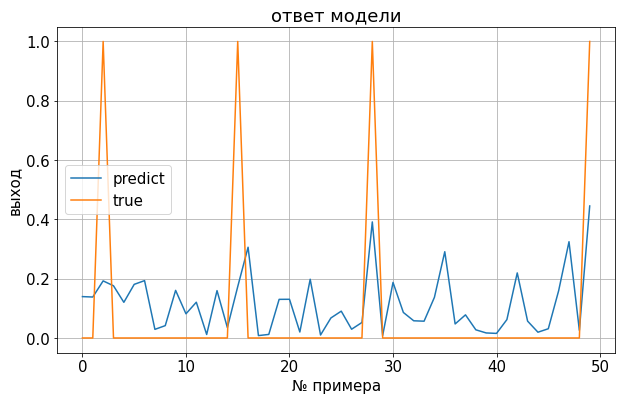

In [239]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [240]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.23157067429551265, F-Score=0.549, Precision=0.490, Recall=0.624


In [241]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1596  159]
 [  93  152]]


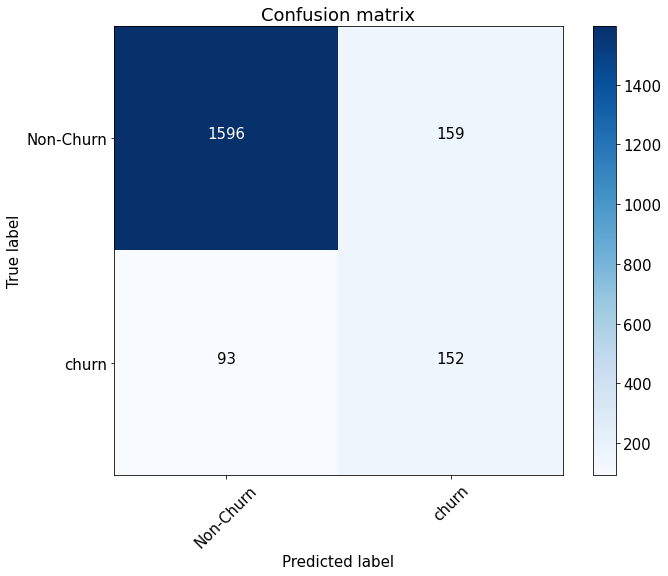

In [242]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [243]:
roc_auc_score(y_test, preds)

0.90431536717251

### Задание №2

***Модифицируем код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана:***

In [244]:
def get_user_embedding_median(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0)  # можно не среднее
    return user_vector

In [245]:
%%time
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x, doc_dict))])
user_embeddings_median.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings_median.head(3)

Wall time: 931 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.0,0.0,0.084121,0.0,0.028441,0.000000,0.031926,0.000000,0.000000,...,0.170183,0.000000,0.025695,0.000000,0.081745,0.000000,0.0,0.000000,0.000000,0.0
1,u108690,0.0,0.0,0.022631,0.0,0.000000,0.000000,0.113668,0.000000,0.023894,...,0.000000,0.033650,0.005609,0.031029,0.161338,0.015319,0.0,0.098508,0.126632,0.0
2,u108339,0.0,0.0,0.121536,0.0,0.006788,0.022742,0.022597,0.007048,0.039933,...,0.000000,0.067575,0.019099,0.012979,0.189953,0.016256,0.0,0.033227,0.051434,0.0


In [246]:
target = pd.read_csv('./users_churn.csv')
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [247]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.0,0.084121,0.0,0.028441,0.000000,0.031926,0.000000,0.000000,...,0.000000,0.025695,0.000000,0.081745,0.000000,0.0,0.000000,0.000000,0.0,0
1,u108690,0.0,0.0,0.022631,0.0,0.000000,0.000000,0.113668,0.000000,0.023894,...,0.033650,0.005609,0.031029,0.161338,0.015319,0.0,0.098508,0.126632,0.0,1
2,u108339,0.0,0.0,0.121536,0.0,0.006788,0.022742,0.022597,0.007048,0.039933,...,0.067575,0.019099,0.012979,0.189953,0.016256,0.0,0.033227,0.051434,0.0,1


In [248]:
# разделим данные на train/test
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_median[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X_median['churn'], random_state=0)

In [249]:
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train_median, y_train_median)

LogisticRegression()

In [250]:
# наши прогнозы для тестовой выборки
preds_median = logreg.predict_proba(X_test_median)[:, 1]
preds_median[:10]

array([0.17210753, 0.06190006, 0.34914379, 0.17633737, 0.11495948,
       0.07578788, 0.13947321, 0.01582876, 0.02887875, 0.24077189])

#### Рассчитаем Precision, Recall, F_score

In [251]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test_median, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix = np.argmax(fscore_median)
print(f'Best Threshold={thresholds_median[ix]}, F-Score={fscore_median[ix]:.3f}, Precision={precision_median[ix]:.3f}, Recall={recall_median[ix]:.3f}')

Best Threshold=0.2606135837881928, F-Score=0.727, Precision=0.663, Recall=0.804


In [252]:
roc_auc_score_median = roc_auc_score(y_test_median, preds_median)
roc_auc_score_median

0.9599976742833887

***Сохраним результат в таблице как Result_median/***

### Задание №3

***Модифицируем код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а максимальные значения:***

In [253]:
def get_user_embedding_max(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0)  # можно не среднее
    return user_vector

In [254]:
%%time
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x, doc_dict))])
user_embeddings_max.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings_max.head(3)

Wall time: 503 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.0,0.205685,0.018098,0.289440,0.142307,0.257400,0.000000,0.076176,...,0.375172,0.256138,0.131550,0.564811,0.277654,0.113351,0.131988,0.181572,0.194494,0.045084
1,u108690,0.015968,0.0,0.154960,0.000000,0.047244,0.102617,0.175678,0.097955,0.110392,...,0.082441,0.151327,0.308506,0.264442,0.374668,0.026203,0.098021,0.306119,0.309916,0.116002
2,u108339,0.062680,0.0,0.236857,0.000000,0.059822,0.151449,0.155002,0.054001,0.127940,...,0.029112,0.122986,0.265764,0.083412,0.325353,0.094831,0.218471,0.210505,0.329313,0.034092


In [255]:
target = pd.read_csv('./users_churn.csv')
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [256]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.0,0.205685,0.018098,0.289440,0.142307,0.257400,0.000000,0.076176,...,0.256138,0.131550,0.564811,0.277654,0.113351,0.131988,0.181572,0.194494,0.045084,0
1,u108690,0.015968,0.0,0.154960,0.000000,0.047244,0.102617,0.175678,0.097955,0.110392,...,0.151327,0.308506,0.264442,0.374668,0.026203,0.098021,0.306119,0.309916,0.116002,1
2,u108339,0.062680,0.0,0.236857,0.000000,0.059822,0.151449,0.155002,0.054001,0.127940,...,0.122986,0.265764,0.083412,0.325353,0.094831,0.218471,0.210505,0.329313,0.034092,1


In [257]:
# разделим данные на train/test
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X_max['churn'], random_state=0)

In [258]:
logreg.fit(X_train_max, y_train_max)

LogisticRegression()

In [259]:
preds_max = logreg.predict_proba(X_test_max)[:, 1]
preds_max[:10]

array([0.15230757, 0.0289461 , 0.44706526, 0.03755296, 0.01155744,
       0.04213013, 0.09631645, 0.18267694, 0.04602358, 0.32031972])

#### Рассчитаем Precision, Recall, F_score

In [260]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test_max, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix = np.argmax(fscore_max)
print(f'Best Threshold={thresholds_max[ix]}, F-Score={fscore_max[ix]:.3f}, Precision={precision_max[ix]:.3f}, Recall={recall_max[ix]:.3f}')

Best Threshold=0.28388983902893117, F-Score=0.735, Precision=0.677, Recall=0.804


In [261]:
roc_auc_score_max = roc_auc_score(y_test_max, preds_max)
roc_auc_score_max

0.9543392057677772

In [265]:
df = pd.DataFrame([[roc_auc_score(y_test, preds), thresholds[ix], round(fscore[ix],3), round(precision[ix],3), round(recall[ix],3)], 
                   [roc_auc_score_median, thresholds_median[ix], round(fscore_median[ix],3), round(precision_median[ix],3), round(recall_median[ix],3)], 
                   [roc_auc_score_max, thresholds_max[ix], round(fscore_max[ix],3), round(precision_max[ix],3), round(recall_max[ix],3)]],
     index=['Result_mean', 'Result_median', 'Result_max'],
     columns=['ROC-AUC', 'Treshold', 'F-Score', 'Precision', 'Recall'])
df

,ROC-AUC,Treshold,F-Score,Precision,Recall
Result_mean,0.904315,0.246203,0.540,0.509,0.576
Result_median,0.959998,0.428311,0.461,0.865,0.314
Result_max,0.954339,0.283890,0.735,0.677,0.804


#### ВЫВОД: данные, полученные в процессе тестирования модели с применение трех различных подходов к векторному представлению пользователей показали, что метод усреднения значений (mean) выдал , можно сказать, средневзевешенный, сбалансированный результат, где precision и recall имеют максимальные значения. Максимизация дала самое большое значение recall, а значит этот метод хорошо может подойти в случаях когда необходимо пользователю выдать наиболее полный список интересующих его тем. Медианные значения дали наиболее высокую точность в подборе тем для пользователя.